# 4.1 Наивный байес и центроидный классификатор

Пусть в наивном байесовском классификаторе классы имеют одинаковые априорные вероятности. Пусть задана плотность распреденения признаков в каждом классе $P(x^{(k)}|y)=\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x^{(k)}-\mu_{yk})^2}{2\sigma^2}}$. Здесь $x^{(k)}, k=\overline{1,n} ,$ - признаки объекта $x$.
По определению, наивный байесовский классификатор относит $x_0$ к классу, для которого максимальна вероятность $p(y|x_0)\sim p(y)p(x^{(1)}=x_0^{(1)}\ \& \dots \&\ x^{(n)}=x_0^{(n)}|y) = p(y) \prod_{k=0}^n p(x^{(k)}=x_0^{(k)}|y)$ (наивный байесовский классификатор использует предположение о независимости признаков). Далее, можно отбросить $p(y)$, так как априорные вероятности классов по условию одинаковы. Подставляя выражение для распределения признаков из условия, получим $p(y|x_0)\sim\prod_{i=0}^n p(x^{(n)}=x_0^{(n)}|y) = (2\pi\sigma^2)^{-\frac{n}{2}}exp(-\frac{1}{2\sigma^2}\sum_{k=0}^n(x_0^{(k)}-\mu_{yk})^2)$. Далее отбрасываем постоянный (одинаковый для всех классов $y$) множитель и получаем $p(y|x_0)\sim exp(-\frac{1}{2\sigma^2}\sum_{k=0}^n(x_0^{(k)}-\mu_{yk})^2)$.

Далее, отметим, что $\sum_{k=0}^n(x_0^{(k)}-\mu_{yk})^2$ - не что иное, как квадрат евклидова расстояния $\rho(x_0,\mu_y)$ между точкой $x_0$ и центром $\mu_y$ класса $y$ в $n$-мерном пространстве признаков. Тогда $p(y|x_0)\sim exp(-\frac{1}{2\sigma^2} \rho(x_0,\mu_y)^2)$: вероятность попадания в класс зависит только от расстояния до его центра. Более того, несложно убедиться (см. рис.), что данная функция убывает по расстоянию.


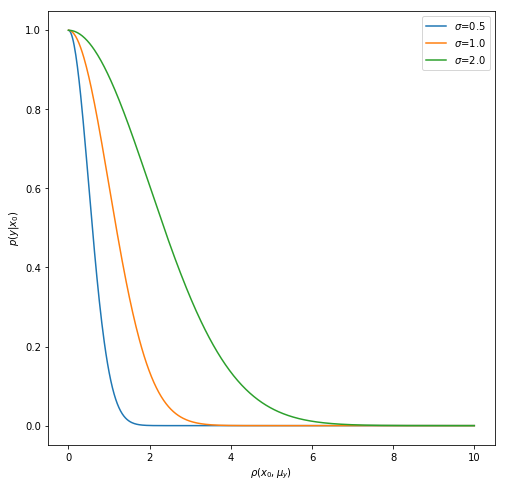

In [11]:
from matplotlib import pyplot
import numpy as np
%matplotlib inline
x = np.linspace(0,10,500)
sigmas = [0.5, 1.0, 2.0]
y = [np.exp(-1*x**2/(2*(sigma**2))) for sigma in sigmas]
pyplot.figure(figsize=(8,8))
for i in xrange(len(sigmas)):
    pyplot.plot(x,y[i],label=r"$\sigma$={}".format(sigmas[i]))
pyplot.xlabel(r"$\rho(x_0,\mu_y)$")
pyplot.ylabel(r"$p(y|x_0)$")
pyplot.legend()

Таким образом, вероятность попадания в класс определяется только расстоянием до его центра и зависит от него обратно. Наивный байесовский классификатор выбирает тот класс, вероятность попадания в который максимальна. Следовательно, объект попадает в тот класс, центр которого находится ближе всего, что и требовалось доказать.

Можно проиллюстрировать полученный результат. Создадим выборку из точек на плоскости нескольких классов и построим разделяющие поверхности с использованием классификатора GaussianNB. Чтобы распределения соответствовали формуле, сделаем разбросы точек в пределах классов одинаковыми. Из геометрических соображений разделяющие поверхности должны быть прямыми, равноудалёнными от центров класов.

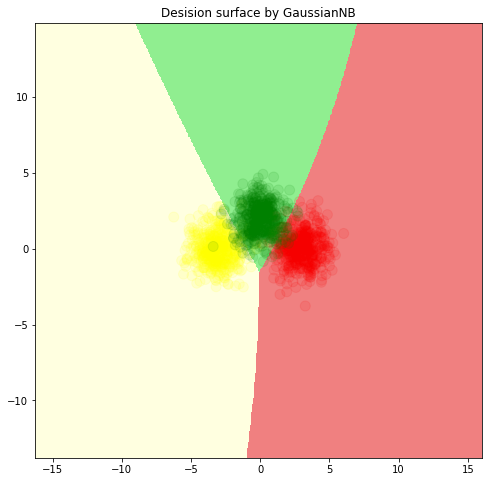

In [36]:
from scipy.stats import multivariate_normal
from sklearn import naive_bayes
def get_meshgrid(data, step=.015, border=.5):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

def plot_decision_surface(sample, classes):
    clf = naive_bayes.GaussianNB()
    clf.fit(sample, classes)
    
    pyplot.figure(figsize = (8, 8))
    
    xgrid, ygrid = get_meshgrid(sample, step = .05, border=10)
    mesh_predictions = np.array(clf.predict(np.c_[xgrid.ravel(), ygrid.ravel()])).reshape(xgrid.shape)
    pyplot.pcolormesh(xgrid, ygrid, mesh_predictions, cmap = light_colors)
    pyplot.scatter(sample[:, 0], sample[:, 1], c = classes, s = 100, cmap = basic_colors, alpha=0.1)
    
    pyplot.title('Desision surface by GaussianNB')

mean1=[3,0]
mean2=[-3,0]
mean3=[0,2]
sigma=[[1,0],[0,1]]
features = np.concatenate((multivariate_normal.rvs(size=500,mean=mean1,cov=sigma),
                          multivariate_normal.rvs(size=500,mean=mean2,cov=sigma),
                          multivariate_normal.rvs(size=500,mean=mean3,cov=sigma)), axis=0)
target = np.concatenate((np.zeros(500), np.ones(500), 2* np.ones(500)),axis=0)



    
from matplotlib.colors import ListedColormap
basic_colors = ListedColormap(['red', 'blue', 'yellow', 'green'])
light_colors = ListedColormap(['lightcoral', 'lightblue', 'lightyellow', 'lightgreen'])

plot_decision_surface(features,target)

Похоже на прямые. Искажения вносятся из-за несимметричности случайных выборок.

# 4.2 ROC-AUC случайных ответов
В треугольном ROC-AUC двухзвенная ломаная ROC строится по трём точкам: $(0,0)$ и $(1,1)$ зафиксированы, третья отражает реальные значения $FPR$ и $TPR$ для классификатора. При этом $AUC=0.5$ соответствует прямой, проходящей через $(0,0)$ и $(1,1)$. Следовательно, достаточно показать, что для рассматриваемого классификатора в среднем $FPR=TPR$: при этом третья точка будет принадлежать той же прямой.

По определению $TPR=\frac{\text{True positives}}{\text{True positives + False negatives}},\ \ FPR=\frac{\text{False positives}}{\text{False positives + True negatives}}$

Вычислим показатели для данного классификатора. Обозначим $c(x)$ истинный класс объекта $x$. Пусть доля объектов класса $1$. равна $q \in [0,1]$

$p(\text{True positive}) = p(a(x)=1\ |\ c(x)=1) = \frac{p(c(x)=1\ \& \ p(a(x)=1)}{p(c(x)=1} = \frac{qp}{q} = p$

Мы воспользовались тем, что ответ классификатора и истинный класс, очевидно, независимы.

$p(\text{False negative}) = p(a(x)=0\ |\ c(x)=1) = \frac{p(c(x)=1\ \& \ p(a(x)=0)}{p(c(x)=1} = \frac{q(1-p)}{q} = 1-p$

$TPR = \frac{\text{True positives}}{\text{True positives + False negatives}} = \frac {1}{1 + \frac{\text{False negatives}}{\text{True positives}}} \approx \frac {1}{1 + \frac{p(\text{False negative})}{p(\text{True positive})}} = \frac {1}{1 + \frac{1-p}{p}} = \frac{p}{p+1-p}=p$

Теперь вычислим аналогичным образом $FPR$.

$p(\text{False positive}) = p(a(x)=1\ |\ c(x)=0) = \frac{p(c(x)=0\ \& \ p(a(x)=1)}{p(c(x)=0} = \frac{(1-q)p}{1-q} = p$

$p(\text{True negative}) = p(a(x)=0\ |\ c(x)=0) = \frac{p(c(x)=0\ \& \ p(a(x)=0)}{p(c(x)=0} = \frac{(1-q)(1-p)}{1-q} = 1-p$

$FPR = \frac{\text{False positives}}{\text{False positives + True negatives}} = \frac {1}{1 + \frac{\text{True negatives}}{\text{False positives}}} \approx \frac {1}{1 + \frac{p(\text{True negative})}{p(\text{False positive})}} = \frac {1}{1 + \frac{1-p}{p}} = \frac{p}{p+1-p}=p$

Получили в среднем $FPR=TPR=p$, что и требовалось доказать.


В качестве иллюстрации смоделируем случайный классификатор и вычислим метрику $ROC-AUC$ на нескольких выборках.

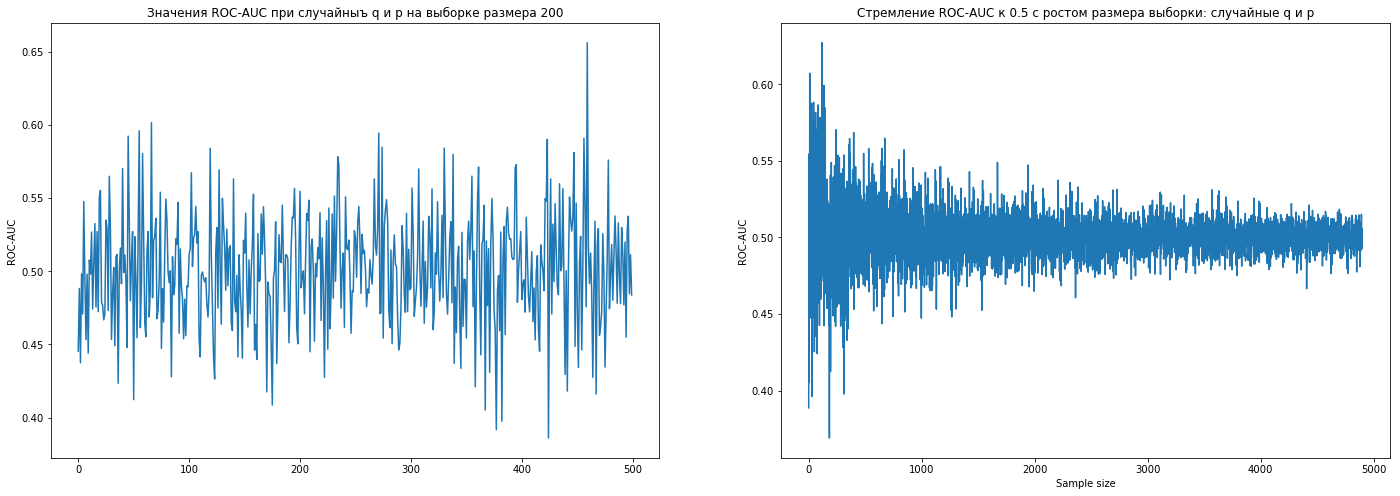

In [114]:
import random
from sklearn.metrics import roc_auc_score

roc_auc_random_qp=[]
roc_auc_extending_sample=[]
roc_auc_extending_sample_const=[]
def a(x):
    if(random.random() < p):
        return 1
    else:
        return 0

for i in xrange(500):
    q=(random.random()+0.1) / 1.2
    p=(random.random()+0.1) / 1.2
    sample = np.concatenate((np.zeros(int(200*(1-q))), np.ones(int(200*q))),axis=0)
    answer = [a(x) for x in sample]
    roc_auc_random_qp.append(roc_auc_score(sample,answer))

for i in xrange(100,5000):
    q=(random.random()+0.1) / 1.2
    p=(random.random()+0.1) / 1.2
    sample = np.concatenate((np.zeros(int(i*(1-q))), np.ones(int(i*q))),axis=0)
    answer = [a(x) for x in sample]
    roc_auc_extending_sample.append(roc_auc_score(sample,answer))


pyplot.figure(figsize=(24,8))
pyplot.subplot(1,2,1)
pyplot.plot(range(500), roc_auc_random_qp, label="ROC-AUC")
pyplot.ylabel("ROC-AUC")
pyplot.title(u"Значения ROC-AUC при случайныъ q и p на выборке размера 200")

pyplot.subplot(1,2,2)
pyplot.plot(range(len(roc_auc_extending_sample)), roc_auc_extending_sample)
pyplot.ylabel("ROC-AUC")
pyplot.xlabel("Sample size")
pyplot.title(u"Стремление ROC-AUC к 0.5 с ростом размера выборки: случайные q и p")

В самом деле, при случайно выбираемых $q$ и $p$ значения метрики $ROC-AUC$ колеблются в узкой полосе возле $0.5$, а при росте выборки (из соображений ЗБЧ и ЦПТ) становятся всё более близки к $0.5$.

# 4.3 Ошибка 1NN и оптимального байесовского классификатора

Рассмотрим задачу бинарной классификации, решаемую двумя классификаторами: оптимальным байесовским и 1NN. Известны выражения для их ошибок. Для байесовского классификатора $y = argmax\ p(y\ |\ x) = argmax\ p(x\ |\ y) p(y) \sim max\{p(x\ |\ 0), p(x\ |\ 1)\}$, поэтому его вероятность ошибки $P_{err}(NB) = min\{p(x\ |\ 0), p(x\ |\ 1)\}$.

Для 1NN-классификатора вероятность ошибки есть вероятность того, что данный объект $x$ и его сосед $x_n$ принадлежат к разным классам: $P_{err}(1NN) = p(x\ |\ 0) p(x_n \ |\ 1) + p(x\ |\ 1) p(x_n \ |\ 0) \rightarrow 2 p(x\ |\ 0)p(x\ |\ 1)$ при стремлении расстояния до ближайшего соседа к нулю.

Отметим, что одно из $p(x\ |\ 0),\ p(x\ |\ 1)$ из приведённых выше соображений равно $P_{err}(NB)$, причём их сумма равняется единице. Тогда $P_{err}(1NN)  \sim 2 p(x\ |\ 0)p(x\ |\ 1) = 2P_{err}(NB)(1-P_{err}(NB)) = 2P_{err}(NB) - 2P_{err}(NB)^2 \le 2 P_{err}(NB)$

Асимптотически $P_{err}(1NN) \le 2 P_{err}(NB)$, что и требовалось доказать.

Проиллюстрируем эту оценку. Чтобы байесовский классификатор был оптимальным для выборки, возьмём Gaussian NB и сгенерируем двухмерную нормальную выборку. Будем увеличивать размер выборки и посмотрим на то, как с её ростом меняется качество прогнозов GaussianNB и 1NN классификаторов в 5-fold кросс-валидации.

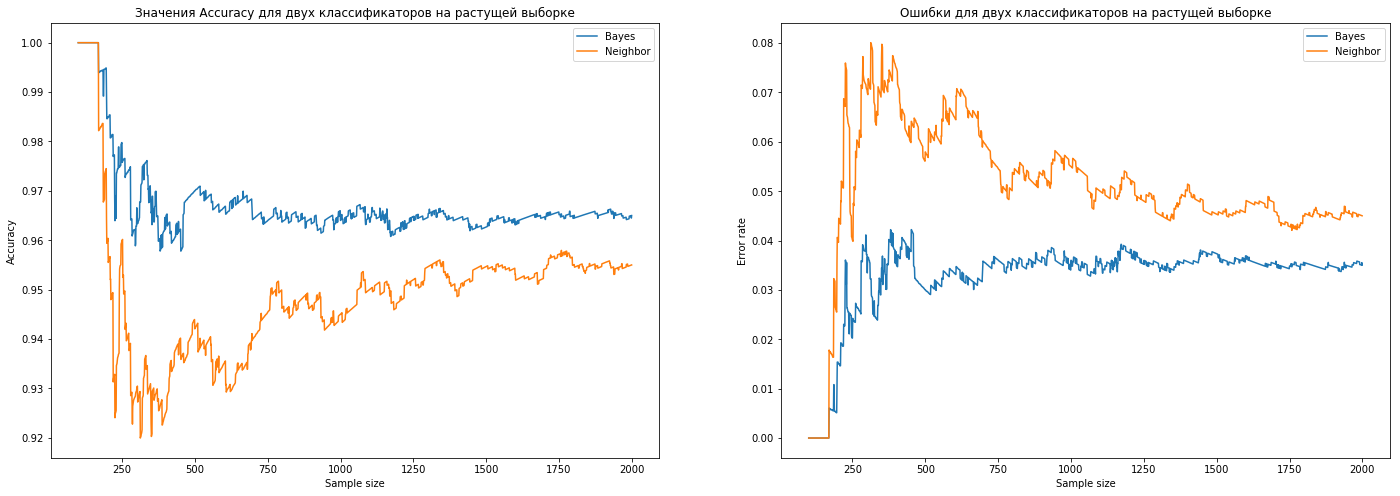

In [113]:
from sklearn import model_selection, naive_bayes, neighbors

bayes_score = []
neighbor_score = []
size_range = range(100,2000)

mean1=[3,0]
mean2=[0,2]
sigma=[[1,0],[0,1]]
features = np.concatenate((multivariate_normal.rvs(size=1000,mean=mean1,cov=sigma),
                          multivariate_normal.rvs(size=1000,mean=mean2,cov=sigma)), axis = 0)
target = np.concatenate((np.zeros(1000), np.ones(1000)), axis = 0)
shuffle = range(0,len(features))
random.shuffle(shuffle)
shuffled_features = [features[i] for i in shuffle]             
shuffled_target = [target[i] for i in shuffle]             

for size in size_range:
    bayes_score.append(model_selection.cross_val_score(naive_bayes.GaussianNB(), shuffled_features[:size],
                                                       shuffled_target[:size], scoring='accuracy', cv = 5).mean())
    neighbor_score.append(model_selection.cross_val_score(neighbors.KNeighborsClassifier(n_neighbors=1),
                                                          shuffled_features[:size], shuffled_target[:size],
                                                          scoring='accuracy', cv = 5).mean())
    
pyplot.figure(figsize=(24,8))
pyplot.subplot(1,2,1)
pyplot.plot(size_range, bayes_score, label="Bayes")
pyplot.plot(size_range, neighbor_score, label="Neighbor")
pyplot.legend()
pyplot.xlabel("Sample size")
pyplot.ylabel("Accuracy")
pyplot.title(u"Значения Accuracy для двух классификаторов на растущей выборке")

bayes_err = np.ones(len(bayes_score)) - bayes_score
neighbors_err = np.ones(len(neighbor_score)) - neighbor_score

pyplot.subplot(1,2,2)
pyplot.plot(size_range, bayes_err, label="Bayes")
pyplot.plot(size_range, neighbors_err, label="Neighbor")
pyplot.legend()
pyplot.xlabel("Sample size")
pyplot.ylabel("Error rate")
pyplot.title(u"Ошибки для двух классификаторов на растущей выборке")



